In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false;}

<IPython.core.display.Javascript object>

In [3]:
import tellurium as te 
import numpy as np 
import matplotlib.pyplot as plt
import ipywidgets as widgets 
from enum import Enum
from IPython.display import display
from IPython.core.display import HTML

In [4]:
# Excitation and inhibition dictionaries

excite = {
  'komarova': lambda pop, k: f'{pop}/{k}',
  'lander':   lambda pop, a: f'{pop}/(1+{a}*{pop})',
  'hill':     lambda pop, a, n=4: f'({pop}^{n})/(1+({a}*{pop})^{n})',
}

inhib = {
  'komarova': lambda pop, k: f'1-({pop}/{k})',
  'lander':   lambda pop, a: f'1/(1+{a}*{pop})',
  'hill':     lambda pop, a, n=4: f'1/(1+({a}*{pop})^{n})',
}



In [5]:
# Defining all functions: 

In [6]:
# Defining two stage model generator. 

def twoCompartmentModel(STEM='1', DIFF='0',
                        L='0.5', P='0.5', D='0.1',
                        Control=['1','1','1'], Events=[]):

    if (float(L)>1 or float(P)>1 or float(D)>1):
        raise ValueError('L, P, and D must be less than or equal to 1.')


    eventString = '\n'.join(Events)

    return  f"""
    # Initialized Populations
    STEM = {STEM};
    DIFF = {DIFF};

    # Parameters 
    L = {L}; P = {P}; D = {D};
    
    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; L * STEM * ({Control[0]});

    # Rate of Differentiation of Stem Cells
    ES_D:  STEM -> DIFF; P * 2 * L * STEM * ({Control[1]});

    # Rate of Death of Differentiated Cells 
    ED_D: DIFF -> ; D * DIFF * ({Control[2]});

    #Events 
    {eventString}
    """

In [7]:
#Defining three stage model generator. 

def threeCompartmentModel(STEM='1', INTER='0', DIFF='0',
                        L_S='0.5', P_S='0.5', 
                        L_I='0.5', P_I='0.5',
                        D='0.1',
                        Control=['1','1','1','1','1'], Events=[]):

    eventString = '\n'.join(Events)

    return  f"""
    # Initialized Populations
    STEM = {STEM};
    INTER = {INTER};
    DIFF = {DIFF};

    # Parameters
    L_S = {L_S}; P_S = {P_S}; L_I = {L_I}; P_I = {P_I}; DEATH = {D};

    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; L_S * STEM * ({Control[0]});

    # Rate of Differentiation of Stem Cells
    ES_I:  STEM -> INTER; P_S * 2 * L_S * STEM * ({Control[1]});

    # Rate of Division of Intermediate Cells
    EI_2I: INTER -> 2INTER; L_I * INTER * ({Control[2]});

    # Rate of Differentiation of Intermediate Cells
    ES_D:  INTER -> DIFF; P_I * 2 * L_I * INTER * ({Control[3]});

    # Rate of Death of Differentiated Cells 
    ED_D: DIFF -> ; DEATH * DIFF * ({Control[4]});

    #Events
    {eventString}
    """

In [8]:
def getMathematicaODEs(r):
  str = te.getODEsFromModel(r)
  strList = str.split('\n')[1:-1]
  rateDict = {}
  outStr = ''

  ratesflag = False

  for i in strList:
    if i == '':
      ratesflag = True
    elif not ratesflag:
      k, v = i.split(' = ')
      rateDict[k] = v
    else:
      str = ''
      for j in i.split(' '):
        if j in rateDict:
          str += rateDict[j]
        else:
          str += j
      outStr += f'{str}\n'
  return outStr

In [9]:
# PLOT FLOW DIAGRAMS
def plotFlow(modelStr: str,      # Antimony model string
                    max: float = 10, # max initial value
                    compartments: int = 3 # number of compartments
                    ):
  steps = 16 # number of steps between 0 and max
  nCurves = steps*1j # the number of curves that you want to plot
  n = np.arange(steps) # number to iterate over in for loops

  increments = np.mgrid[0:max:nCurves] # an array of all initial values

  U, V = np.mgrid[0:max:nCurves, 0:max:nCurves] # two n x n arrays to store population values at time t+1

  r = te.loada(modelStr) # load the model

  if compartments == 2:
    ogVals = {'STEM': r.STEM, 'DIFF': r.DIFF} # store the original initial population values of the model
    cellTypes = ['STEM', 'DIFF'] # list of cell types

  elif compartments == 3:
    ogVals = {'STEM': r.STEM, 'INTER': r.INTER, 'DIFF': r.DIFF}
    cellTypes = ['STEM', 'INTER', 'DIFF']

  # Create 3 subplots that are horizontally stacked
  _, ax = plt.subplots(1, compartments, sharey=False, figsize=(20, 5), dpi=128)

  # Iterate over each cell type
  for i in np.arange(compartments):
    cellA = cellTypes[i]        # the cell type plotted on the x-axis
    cellB = cellTypes[(i+1)%compartments]  # the cell type plotted on the y-axis

    if compartments == 3:
      cellX = cellTypes[(i-1)%compartments]  # the cell type that is not plotted

      r[cellX] = ogVals[cellX]    # set the cell type that is not plotted to its original value

    # iterate over the x-axis
    for x in n:
      r[cellA] = increments[x]    # set the initial value of the x-axis cell type

      # iterate over the y-axis
      for y in n:
        r[cellB] = increments[y]  # set the initial value of the y-axis cell type

        U[y,x] = r[f"{cellA}'"]   # store the value of the x-axis cell type at time t+1
        V[y,x] = r[f"{cellB}'"]   # store the value of the y-axis cell type at time t+1

    ax[i].set_xlabel(cellA, fontsize='12')
    ax[i].set_ylabel(cellB, fontsize='12')

    ax[i].streamplot(increments,increments,U, V, density=[2, 2]) # Plot the Flow

  plt.show()  

In [10]:
# # Bifurcation scans
    
# First version
def printHighLowBifurcationScan(modelStr: str,
                                scanningParam: str = 'L_S',                                
                                population: str = 'STEM',
                                range: np.array = np.arange(0, 1, 0.01),                                
                                lowInit: float = 0.1,
                                highInit: float = 10.,
                                simulateLen: int = 1000):

  r = te.loada(modelStr)
  results = np.empty([0,3])
  for param in range:
    r.resetAll()

    r[population] = lowInit      
    r[scanningParam] = param
    m = r.simulate(0, simulateLen, 1000)
    lowEnding = r[population]
    r.resetAll()

    r[population] = highInit
    r[scanningParam] = param      
    m = r.simulate(0, simulateLen, 1000)
    highEnding = r[population]

    newRow = [param, lowEnding, highEnding]
    results = np.vstack([ results, newRow ])

  te.plotArray(results,
              title=f"Bifurcation Scan {scanningParam}", 
              resetColorCycle=False, 
              xlabel=scanningParam,
              ylabel='Population',
              labels=[ f"{population}0 = {lowInit}", f"{population}0 = {highInit}" ])


In [11]:
def plotFlow3Compartment(STEM, INTER, DIFF,L_S,P_S,L_I,P_I,D,controlType,controlParam):
  model = threeCompartmentModel(
    STEM, INTER, DIFF, 
    L_S,P_S,
    L_I,P_I,
    D,
    Control=[inhib[controlType]('STEM',str(controlParam)), inhib[controlType]('INTER',str(controlParam)), inhib[controlType]('DIFF',str(controlParam)), '1','1'],
    Events=[])
  plotFlow(model, max=100)

In [12]:
def modelGeneratorTWO(STEM_value: int, DIFF_value: int, L_value: float, P_value: float, D_value: float,# Inintial values 
                      Control_typeFirst: str, Control_typeSecond: str, Control_typeThird: str,         # inhib, excite or none
                      Control_design: str,                                                             # Komarova, Lander or Hill                      
                      Control_speciesFirst: str, Control_speciesSecond: str, Control_speciesThird: str,# STEM, DIFF
                      Control_kFirst: str, Control_kSecond: str, Control_kThird: str,                  # value of a
                      Events_T: bool,                                                                  # enable event 
                      Events_time: int, Events_species: str, Events_Svalue: int,                       # event parameters
                      Simulate_time: int):                                                             # Max Time of the simulation
    
    # Quick fix for division by zero when using Komarova
    if (Control_design == 'komarova'
        and (Control_kFirst==0      and  (not Control_typeFirst  == 'None')
             or Control_kSecond==0  and  (not Control_typeSecond == 'None')
             or Control_kThird==0   and  (not Control_typeThird  == 'None') )):
        raise ZeroDivisionError(display(HTML('<h1 style="color:magenta;">Division by Zero Error</h1>\n<h3 style="color:magenta;">Komarova needs values of a >= 1 </h3>'))
)     
    
    # Parameter definition    
    Control_value=[]
    # S->2S
    if Control_typeFirst == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesFirst, str(Control_kFirst)))
    elif Control_typeFirst == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesFirst, str(Control_kFirst)))  
    else:        
        Control_value.append('1')  
    # S->D
    if Control_typeSecond == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesSecond, str(Control_kSecond)))
    elif Control_typeSecond == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesSecond, str(Control_kSecond)))  
    else:        
        Control_value.append('1')  
    # D-> 
    if Control_typeThird == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesThird, str(Control_kThird)))
    elif Control_typeThird == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesThird, str(Control_kThird)))  
    else:        
        Control_value.append('1')          
  
    # Event definition    
    if Events_T:                
        Events_value=['at time > {t}: {s} = {v};'.format(t=Events_time, s=Events_species, v=Events_Svalue)]
    else:
        Events_value=[]
    
    # Model Generation    
    model = twoCompartmentModel(STEM=STEM_value,DIFF=DIFF_value,L=L_value,P=P_value,D=D_value,Control=Control_value,Events=Events_value) 
    
    # Tellurium Simulation   
    r = te.loada(model)   
    try:    
        s = r.simulate(0, Simulate_time, Simulate_time*10)
        
    except:        
        display(HTML('<h1 style="color:magenta;">Convergence Error</h1>\n<h3 style="color:magenta;">Try a different configuration values are aproaching the limit and cannot converge</h3>'))
        s = r.simulate(0, 0.09, 10)

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    # Population Plotting 
    ax[0].plot(s['time'],s['[STEM]'], label="Stem")
    ax[0].plot(s['time'],s['[DIFF]'], label="Differentiated")
    ax[0].legend()
    ax[0].grid()
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Population')
    ax[0].set_title('Population Graph')

    # Bifurcation Analysis
    printHighLowBifurcationScan(model, scanningParam='L', population= 'STEM') # example not doing what I wanted with axis subplot

    
    # Flow Analysis
    plotFlow(model, compartments=2)

    plt.show()
  

In [13]:
def labelBox(label, widget):
    return widgets.VBox(
        children=[
            widgets.Label(value=label),
            widget
        ]
    )

def slider(min,max,step,value):
    return widgets.FloatSlider(min=min, max=max, step=step, value=value, continuous_update=False, style = {'handle_color': 'lightblue'})

def title(txt):
    return widgets.HTML(f'<font size="+1">{txt}</font>')

In [14]:
def twoCompartmentWidgets():
    # Initial values
    STEM=widgets.FloatSlider(min=0, max=100, step=1, value=1, continuous_update=False)
    STEM.style.handle_color = 'lightblue'

    DIFF=widgets.FloatSlider(min=0, max=100, step=1, value=0, continuous_update=False)
    DIFF.style.handle_color = 'lightblue'

    box1 = widgets.HBox(
        [labelBox('Stem',STEM),        
        labelBox('Differentiated',DIFF)], 
        description='Initial Values')

    L=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
    L.style.handle_color = 'lightblue'

    P=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
    P.style.handle_color = 'lightblue'

    D=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.1, continuous_update=False)
    D.style.handle_color = 'lightblue'

    # Control Parameters
    ControlType = widgets.ToggleButtons(options=[('Komarova', 'komarova'), ('Lander', 'lander'), ('Hill', 'hill')],
                                        disabled=False, button_style='info',
                                        tooltips=['Promote = pop/a\nInhibit = 1-(pop/a)',
                                                'Promote = pop/(1+a*pop)\nInhibit = 1/(1+a*pop)',
                                                'Promote = (pop^4)/(1+(a*pop)^4)\nInhibit = 1/(1+(a*pop)^4)'])

    Control_type1= widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'],
                                            value='None', disabled=False, button_style='info',)
    Control_type2= widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'],
                                            value='None', disabled=False, button_style='info',)
    Control_type3= widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'],
                                            value='None', disabled=False, button_style='info',) 

    controlParam1=widgets.BoundedIntText(value=5,min=0,max=100,step=1,disabled=False)
    controlParam2=widgets.BoundedIntText(value=5,min=0,max=100,step=1,disabled=False)
    controlParam3=widgets.BoundedIntText(value=5,min=0,max=100,step=1,disabled=False)

    Control_species1= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Differentiated', 'DIFF')],
                                            value='STEM', disabled=False, button_style='info',)
    Control_species2= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Differentiated', 'DIFF')],
                                            value='DIFF', disabled=False, button_style='info',)
    Control_species3= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Differentiated', 'DIFF')],
                                            value='STEM', disabled=False, button_style='info',) 

    box4a = widgets.HBox([
        labelBox('Stem → 2Stem',Control_type1),
        labelBox('\'a\' value',controlParam1),
        labelBox('Species Controlling',Control_species1)])

    box4b = widgets.HBox([    
        labelBox('Stem → Differentiated',Control_type2),
        labelBox('\'a\' value',controlParam2),
        labelBox('Species Controlling',Control_species2)])

    box4c = widgets.HBox([
        labelBox('Differentiated → ',Control_type3),
        labelBox('\'a\' value',controlParam3),
        labelBox('Species Controlling',Control_species3)])
    
    # Events Parameters
    Events_T_w= widgets.Checkbox(value=False, disabled=False)

    Events_time_w= widgets.IntSlider(min=0, max=100, step=1, value=50, continuous_update=False)
    Events_time_w.style.handle_color = 'lightblue'

    Events_species_w= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Differentiated', 'DIFF')],
                                                                value='DIFF', disabled=False, button_style='info',)

    Events_Svalue_w= widgets.IntSlider(min=0, max=150, step=1, value=0, continuous_update=False, disabled=False)
    Events_Svalue_w.style.handle_color = 'lightblue'

    Simulate_time_w= widgets.IntSlider(value=200,min=150,max=1500,step=1,description='Text:',disabled=False)
    Simulate_time_w.style.handle_color = 'lightblue'
                        
    box5 = widgets.HBox([
        labelBox('Create an Event',Events_T_w),
        labelBox('Time of Event',Events_time_w),
        labelBox('Species',Events_species_w),
        labelBox('Set Species Value',Events_Svalue_w)    
        ])

    inputs = widgets.VBox([
        title('Initial Populations'),box1,
        title('Division Rates'), L,
        title('Differentiation Probability'), P,
        title('Death Rate'), D,
        title('Control Mechanism'), ControlType,
        title('Division Control Parameters'), box4a,
        title('Differentiation Control Parameters'), box4b,
        title('Death Control Parameters'), box4c,
        title('Simulation Max Time'), Simulate_time_w,
        title('Events'), box5
        ])

    out = widgets.interactive_output(modelGeneratorTWO, {
        'STEM_value':STEM, 'DIFF_value':DIFF,
        'L_value':L,'P_value':P,'D_value':D,
        'Control_design':ControlType,
        'Control_typeFirst':Control_type1,'Control_typeSecond':Control_type2,'Control_typeThird':Control_type3,
        'Control_kFirst':controlParam1,'Control_kSecond':controlParam2,'Control_kThird':controlParam3,
        'Control_speciesFirst': Control_species1, 'Control_speciesSecond':Control_species2, 'Control_speciesThird': Control_species3,
        'Events_T':Events_T_w,'Events_time':Events_time_w, 'Events_species':Events_species_w, 'Events_Svalue':Events_Svalue_w,
        'Simulate_time':Simulate_time_w
        })

    display(inputs,out)
   

In [15]:
def modelGeneratorTHREE(STEM_value: int,INTER_value: int, DIFF_value: int,              # Inintial values
                        L_Ivalue: float,L_Svalue: float,
                        P_Ivalue: float,P_Svalue: float,
                        D_value: float, 
                        
                        Control_typeFirst: str, Control_typeSecond: str,                # inhib, excite or none
                        Control_typeThird: str,  Control_typeFourth: str,
                        Control_typeFifth: str,
                        
                        Control_design: str,                                            # Komarova, Lander or Hill
                             
                        Control_speciesFirst: str, Control_speciesSecond: str,          # STEM, INTER, DIFF
                        Control_speciesThird: str, Control_speciesFourth: str,
                        Control_speciesFifth: str,
                        
                        Control_kFirst: str, Control_kSecond: str, Control_kThird: str, # value of a
                        Control_kFourth: str, Control_kFifth: str,
                        
                        Events_T: bool,                                                 # enable event
                        Events_time: int, Events_species: str, Events_Svalue: int,      # event parameters
                        Simulate_time: int,                                            # Max Time of the simulation
                        BifurcationSpecies: str, BifurcationParam: str):
      
    # Quick fix for division by zero when using Komarova
    if (Control_design == 'komarova'
        and (Control_kFirst==0      and  (not Control_typeFirst  == 'None')
             or Control_kSecond==0  and  (not Control_typeSecond == 'None')
             or Control_kThird==0   and  (not Control_typeThird  == 'None') )):
        raise ZeroDivisionError(display(('<h1 style="color:magenta;">Division by Zero Error</h1>\n<h3 style="color:magenta;">Komarova needs values of a >= 1 </h3>'))
) 
                                      
    
    # Parameter definition
    Control_value=[]
    # S->2S
    if Control_typeFirst == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesFirst, Control_kFirst))
    elif Control_typeFirst == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesFirst, Control_kFirst))  
    else:        
        Control_value.append('1')  
    # S->I
    if Control_typeSecond == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesSecond, Control_kSecond))
    elif Control_typeSecond == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesSecond, Control_kSecond))  
    else:        
        Control_value.append('1')  
    # I->2I
    if Control_typeThird == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesThird, Control_kThird))
    elif Control_typeThird == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesThird, Control_kThird))  
    else:        
        Control_value.append('1')                    
    # I->D
    if Control_typeFourth == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesFourth, Control_kFourth))
    elif Control_typeFourth == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesFourth, Control_kFourth))  
    else:        
        Control_value.append('1')       
    # D->
    if Control_typeFifth == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesFifth, Control_kFifth))
    elif Control_typeFifth == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesFifth, Control_kFifth))  
    else:        
        Control_value.append('1')              
    
    # Event definition   
    if Events_T:                
        Events_value=['at time > {t}: {s} = {v};'.format(t=Events_time, s=Events_species, v=Events_Svalue)]
    else:
        Events_value=[]
    
    # Model Generation    
    model = threeCompartmentModel(STEM=STEM_value,INTER=INTER_value,DIFF=DIFF_value,
                                  L_S=L_Svalue, P_S=P_Svalue, 
                                  L_I=L_Ivalue, P_I=P_Ivalue,
                                  D=D_value,Control=Control_value,Events=Events_value) 

    r = te.loada(model)    
    try:    
        s = r.simulate(0, Simulate_time, Simulate_time*10)
        
    except:        
        display(HTML('<h1 style="color:magenta;">Convergence Error</h1>\n<h3 style="color:magenta;">Try a different configuration values are aproaching the limit and cannot converge</h3>'))
        s = r.simulate(0, 0.09, 10)
        
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    # Population Plotting 
    ax[0].plot(s['time'],s['[STEM]'], label="Stem")
    ax[0].plot(s['time'],s['[INTER]'], label="Intermediate")
    ax[0].plot(s['time'],s['[DIFF]'], label="Differentiated")
    ax[0].legend()
    ax[0].grid()
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Population')
    ax[0].set_title('Population Graph')

    # Bifurcation Analysis
    printHighLowBifurcationScan(model, scanningParam=BifurcationParam, population=BifurcationSpecies) # example not doing what I wanted with axis subplot
    
    # Flow Analysis
    plotFlow(model, max=100, compartments=3)
    plt.show()

In [52]:
def threeCompartmentWidgets():
    # Initial Values
    STEM = slider(0,100,1,1)
    INTER = slider(0,100,1,1)
    DIFF = slider(0,100,1,0)

    L_S = slider(0,1,0.01,0.5)
    L_I = slider(0,1,0.01,0.5)

    P_S = slider(0,1,0.01,0.5)
    P_I = slider(0,1,0.01,0.5)

    D = slider(0,1,0.01,0.1)

    box1 = widgets.HBox(
        [labelBox('Stem',STEM),
        labelBox('Intermediate',INTER),
        labelBox('Differentiated',DIFF)])
    
    box2 = widgets.HBox([
        labelBox('Stem',L_S),
        labelBox('Intermediate',L_I)])

    box3 = widgets.HBox([
        labelBox('Stem → Intermediate',P_S),
        labelBox('Intermediate → Differentiated',P_I)])

    # Control Parameters
    ControlMech = widgets.ToggleButtons(options=[('Komarova', 'komarova'), ('Lander', 'lander'), ('Hill', 'hill')],
                                        disabled=False, button_style='info',
                                        tooltips=['Promote = pop/a\nInhibit = 1-(pop/a)',
                                                'Promote = pop/(1+a*pop)\nInhibit = 1/(1+a*pop)',
                                                'Promote = (pop^4)/(1+(a*pop)^4)\nInhibit = 1/(1+(a*pop)^4)'])

    controlType = [widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'], value='None', button_style='info') for i in range(5)]

    controlParams = [widgets.BoundedFloatText(value=5.,min=1.,max=100.,step=1.) for i in range(5)]

    controlSpecies = [widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Intermediate', 'INTER'), ('Differentiated', 'DIFF')], value='STEM', button_style='info') for i in range(5)]

    controlBox = lambda label, i: widgets.HBox([
                labelBox(label,controlType[i]),
                labelBox('\'a\' value',controlParams[i]),
                labelBox('Species Controlling',controlSpecies[i])])
    
    box4 = [controlBox(label,i) for i, label in enumerate(['Stem → 2Stem', 'Stem → Intermediate', 'Intermediate → 2Intermediate', 'Intermediate → Differentiated', 'Differentiated → '])]

    # Events

    Events_T_w= widgets.Checkbox(value=False, disabled=False)

    Events_time_w= widgets.IntSlider(min=0, max=100, step=1, value=50, continuous_update=False, style = {'handle_color': 'lightblue'})

    Events_species_w= widgets.ToggleButtons(options=[('Stem', 'STEM'), ('Intermediate', 'INTER'), ('Differentiated', 'DIFF')], value='DIFF', button_style='info',)

    Events_Svalue_w= widgets.IntSlider(min=0, max=150, step=1, value=0, continuous_update=False, style = {'handle_color': 'lightblue'})

    Simulate_time_w= widgets.IntSlider(value=200, min=150, max=1500, step=1, description='Text:', style = {'handle_color': 'lightblue'})
                        
    box5 = widgets.HBox([
        labelBox('Create an Event?',Events_T_w),
        labelBox('Event Trigger Time',Events_time_w),
        labelBox('Species',Events_species_w),
        labelBox('Set Species Value',Events_Svalue_w)    
        ])
    

    bifucationSpecies= widgets.ToggleButtons(options=[('Stem', 'STEM'), ('Intermediate', 'INTER'), ('Differentiated', 'DIFF')], value='DIFF', button_style='info',)

    bifurcationParam= widgets.Dropdown(options=[('LS (Stem Division)', 'L_S'), ('LI (Intermediate Division)', 'L_I'), ('PS (Stem Differentiation)', 'P_S'), ('PI (Intermediate Differentation)', 'P_I'), ('D (Death Rate)', 'DEATH')], value='L_S')

    box6 = widgets.HBox([
        labelBox('Species', bifucationSpecies),
        labelBox('Parameter', bifurcationParam)
        ])

    inputs = widgets.VBox([
        title('Initial Populations'),           box1,
        title('Division Rates'),                box2,
        title('Differentiation Probability'),   box3,
        title('Death Rate'),                    D,
        title('Control Mechanism'),             ControlMech,
        *box4,
        title('Simulation Time'),               Simulate_time_w,
        title('Events'),                        box5,
        title('Bifurcation Analysis'),          box6,
        ])

    out = widgets.interactive_output(modelGeneratorTHREE, {
        'STEM_value':STEM,'INTER_value':INTER,'DIFF_value':DIFF,
        'L_Ivalue':L_I,'L_Svalue':L_S,
        'P_Ivalue':P_I,'P_Svalue':P_S,
        'D_value':D,
        'Control_design':ControlMech,
        
        'Control_typeFirst':controlType[0],'Control_typeSecond':controlType[1],'Control_typeThird':controlType[2],
        'Control_typeFourth':controlType[3],'Control_typeFifth':controlType[4],
        
        'Control_kFirst':controlParams[0],'Control_kSecond':controlParams[1],'Control_kThird':controlParams[2],
        'Control_kFourth':controlParams[3],'Control_kFifth':controlParams[4],
        
        'Control_speciesFirst': controlSpecies[0], 'Control_speciesSecond':controlSpecies[1],'Control_speciesThird': controlSpecies[2],
        'Control_speciesFourth': controlSpecies[3], 'Control_speciesFifth':controlSpecies[4],
        
        'Events_T':Events_T_w,'Events_time':Events_time_w, 'Events_species':Events_species_w, 'Events_Svalue':Events_Svalue_w,
        'Simulate_time':Simulate_time_w,
        'BifurcationSpecies':bifucationSpecies, 'BifurcationParam':bifurcationParam
        })

    display(inputs,out)    
             

## Introduction

Tissues typically denote heterogeneous cell collectives that often exhibit complex and interesting behavior that would otherwise not be seen in single cells alone. Many of these behaviors, such as maintaining a target morphology, size, or function, are the result of the collective interactions between differenent cell types. In their most generic form, we can understand tissues as being composed of three major types of cells, those being: stem cells, transit-amplifying cells, and differentiated cells. Additionally, we know that these cell types can secrete regulatory factors that can exhibit control on other cell populations. These factors can be understood to have positive or negative feedback loops. By understanding the mechanisms that govern these interactions and the factors that regulate them, we can begin to understand the mechanisms that govern tissue homeostasis and regeneration. This is both vital for the basic concepts that we understand to be true about the biology of tissues, as well as provide a foundation for their application and use in regenerative medicine. Many of the issues that we uncover in degenerative disease, aging, and cancer are the result of a loss of control or a disruption of feedback within the tissue (CITE). An increasing amount of interest has been paid to the use of stem cells to treat these diseases, but the success of these applications is dependent on our ability to understand the mechanisms that govern tissue homeostasis and regeneration (CITE).


There have been several recent implementations of dynamical multistage cell lineage models that examine feedback and control in tissues (Lander et al.,2009; Lo et al.,2009; Nakata et al., 2012; Rodreiguez-Brenes et al., 2013; Komarova, 2013; Yang, Axelrod, and Komarova, 2017). In this application, we replicate and extend this work in order to investigate the qualitative dynamics that can be observed in these topologies. We specifically choose to expand on the models described in Komarova (2013) and Yang et al. (2017), as no a priori assumptions on the type or direction of signalling loops is made. In our implementation of the two and three-stage cell lineage models, we examine the similarities and differences between the different forms of control that can be implemented. Furthermore, many of the qualitative aspects of the models have previously gone unaddressed. Using dynamical systems theory, we highlight many of the qualitative characteristics seen in these models and report on homologous or degenerate solutions.



The most generic and toy form of a multistage cell lineage model can be thought to consist of only stem cells and terminally differentiated cells. For this two stage system, the state variables are the populations of stem cells and the population of terminally differentiated cells.
Komorova (2013) describes the deterministic system as being governed by the following two ODEs:

$$\dot{x} = L(x,y)(1-2P(x,y))$$
$$\dot{y} = 2L(x,y)P(x,y) - D(x,y)$$

where $x$ is the population of stem cells, $y$ is the population of terminally differentiated cells. Stem cells, and subsequent cells in larger networks, have two options: where they divide at a rate $L$ and where they differentiate at a probability $P$. Differentiated cells die at a rate $D$. 

[Need a description of the model way that the parameters relate to each other here]

### A Two-Stage network without control: 

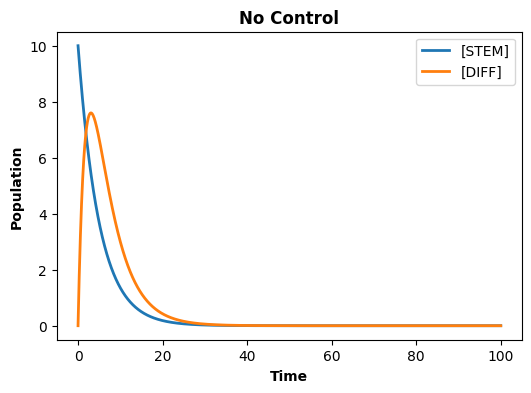

In [53]:
NoControl = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='0.5',P='0.7',D='0.5',
  Control=['1', '1', '1'], 
  Events=[])
r = te.loada(NoControl)
s = r.simulate(0, 100, 10000) 
r.plot(s, title='No Control', xtitle='Time', ytitle='Population')


In the absence of control loops, the network will have a very difficult time maintaining homeostasis and eventually both stem and differentiated populations will decay towards extinction. 

### Two-Stage networks with control: 

Control has been formalized differently throughout the literature. Here, we define three distinct forms of control and examine there affects on two and three compartment systems. 

![](./assets/table.png)

First, the original method of control used by Komarova (2013): Where $Population$ denotes the population of the cell stage that is doing the controlling, and $k$ is a parameter. In their work in the olfactory epithelium, Lander et al. (2009), they use a variation on the tradiational hill function, where the population gets muliplied by the parameter $\alpha$. Lastly, we include a generalized Hill function, where $n$ is an exponential parameter, typically set to either values of 4 or 8. By multiplying the control functions with our parameters, so in the two stage system that would be either our division rate $L$ or our differentiation probability $P$  we can create different network topologies. Excitation and inhibition can be linked in a combinatorial fashion, but not all will produce networks capable of achieving appropriate population homeostasis. In the two stage system specifically, only two network topologies were shown to exhibit tissue homeostasis. Before expanding onto increasingly more complex networks, we will first examine the dynamics of these two networks. 


### Topology 1:

![](./assets/inhib_inhib.png)

In this network, stem cells are inhibiting their own division rate. At the same time, differentiated cells are also inhibiting the probability that stem cells will differentiate. 

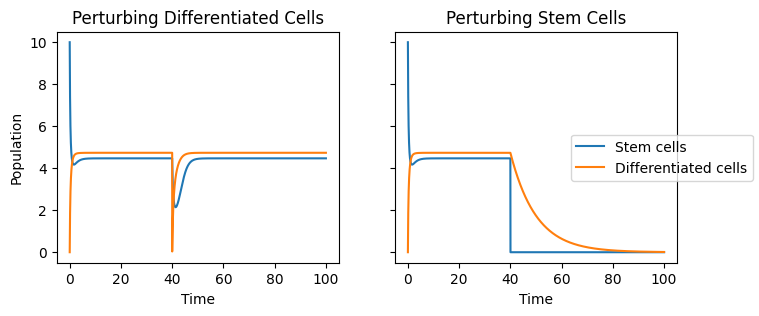

In [54]:
DoubleInhib = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('DIFF','5'), '1'], 
  Events=['at time > 40: DIFF = 0;'])

DoubleInhibFailure = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('DIFF','5'), '1'], 
  Events=['at time > 40: STEM = 0;'])
  
r = te.loada(DoubleInhib)
s1 = r.simulate(0, 100, 10000,['STEM', 'DIFF'])
r = te.loada(DoubleInhibFailure)
s2 = r.simulate(0, 100, 10000,['STEM', 'DIFF'])


time = np.arange(0, 100, 0.01)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,3), sharex=True, sharey=True)
ax1.plot(time, s1)
ax1.set_title('Perturbing Differentiated Cells')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax2.plot(time, s2)
ax2.set_title('Perturbing Stem Cells')
ax2.set_xlabel('Time')

fig.legend(['Stem cells', 'Differentiated cells'], loc='center right')
plt.show()

Here, the initial stem and differentied populations are set to 10 and 0 respectively. We can see that the network clearly exhibits populations homeostasis relative to the parameter $k$ and the tissue is also incredibly robust to perturbations. Even when the differentiated cell popualation is completely destroyed 40 steps into the simulation, the tissue will still be able to recover. Yet, this is not the caae with our stem cell population, as although it can survive slight perturbations, it is not able to recover from a complete destruction of the population in the same way that differentiated cells can.

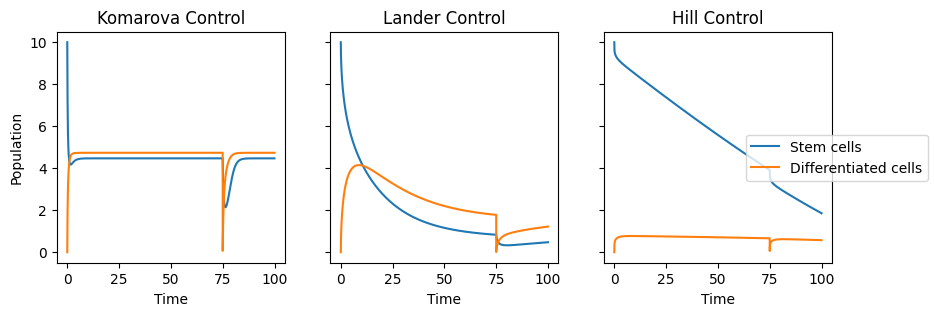

In [55]:
Komarova = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('DIFF','5'), '1'], 
  Events=['at time >75: DIFF = 0'])
Lander = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[inhib['lander']('STEM','5'), inhib['lander']('DIFF','5'), '1'], 
  Events=['at time >75: DIFF = 0'])
Hill = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[inhib['hill']('STEM','5', '4'), inhib['hill']('DIFF','5', '4'), '1'], 
  Events=['at time >75: DIFF = 0'])

r = te.loada(Komarova)
s1 = r.simulate(0, 100, 10000,['STEM','DIFF'])
r = te.loada(Lander)
s2 = r.simulate(0, 100, 10000,['STEM','DIFF'])
r = te.loada(Hill)
s3 = r.simulate(0, 100, 10000,['STEM','DIFF'])

time = np.arange(0, 100, 0.01)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10,3), sharex=True, sharey=True)
ax1.plot(time, s1)
ax1.set_title('Komarova Control')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax2.plot(time, s2)
ax2.set_title('Lander Control')
ax2.set_xlabel('Time')
ax3.plot(time, s3)
ax3.set_title('Hill Control')
ax3.set_xlabel('Time')
fig.legend(['Stem cells','Differentiated cells'], loc='center right')
plt.show()

Here is the same two stage system, the only different being the type of control that is implemented. Overall, each of the control function serves its purpose, yet, in this specific system, the Komarova form of control appears to be most effective in maintaining tissue homeostasis in respect to it's carrying capacity. All control functions seem to be robust to extreme perturbations, even when the differentiated cell population is completely destroyed at around 75 steps into the simulation.

### Topology 2:

![](./assets/excite_inhib.png)

In this network, stem cells are increasing the probability that they will differentiate, while differentiated cells inhibit their rate of division. 

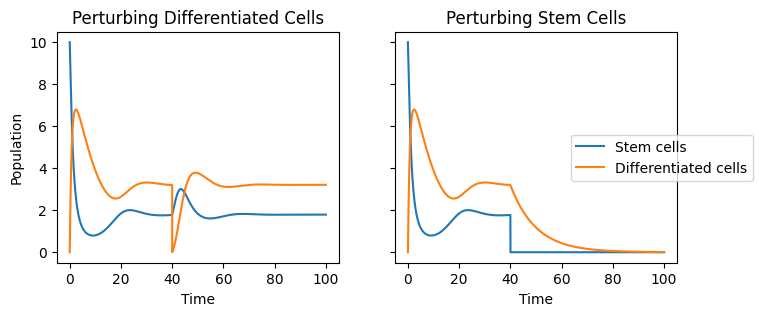

In [56]:
InhibExcite = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='0.5',P='0.5',D='0.1',
  Control=[inhib['komarova']('DIFF','5'), excite['komarova']('STEM','5'), '1'], 
  Events=['at time> 40: DIFF = 0;'])
InhibExciteFail = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='0.5',P='0.5',D='0.1',
  Control=[inhib['komarova']('DIFF','5'), excite['komarova']('STEM','5'), '1'], 
  Events=['at time> 40: STEM = 0;'])

r = te.loada(InhibExcite)
s1 = r.simulate(0, 100, 10000,['STEM', 'DIFF'])
r = te.loada(InhibExciteFail)
s2 = r.simulate(0, 100, 10000,['STEM', 'DIFF'])

time = np.arange(0, 100, 0.01)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,3), sharex=True, sharey=True)
ax1.plot(time, s1)
ax1.set_title('Perturbing Differentiated Cells')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax2.plot(time, s2)
ax2.set_title('Perturbing Stem Cells')
ax2.set_xlabel('Time')

fig.legend(['Stem cells', 'Differentiated cells'], loc='center right')
plt.show()

This is our second network topology that results in tissue homeostasis. Similar to the first network, we can see that it is incredibly robust to damage to it's differentiated cell population. However, also like our first network, it is not able to recover from a complete destruction of the stem cell population. This network also seems to exhibit a mild oscillatory behavior, as the stem and differentiated cell populations deflect in response to one another. 

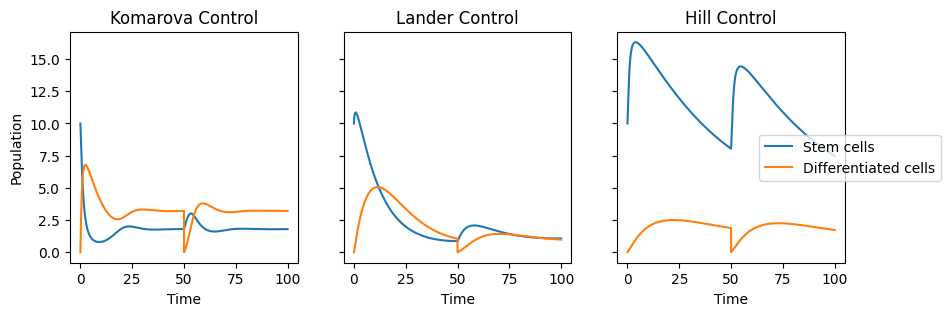

In [57]:
Komarova = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='0.5',P='0.5',D='0.1',
  Control=[inhib['komarova']('DIFF','5'), excite['komarova']('STEM','5'), '1'], 
  Events=['at time > 50: DIFF = 0'])
Lander = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='0.5',P='0.5',D='0.1',
  Control=[inhib['lander']('DIFF','5'), excite['lander']('STEM','5'), '1'], 
  Events=['at time > 50: DIFF = 0'])
Hill = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='0.5',P='0.5',D='0.1',
  Control=[inhib['hill']('DIFF','5','2'), excite['hill']('STEM','5','2'), '1'], 
  Events=['at time > 50: DIFF = 0'])

r = te.loada(Komarova)
s1 = r.simulate(0, 100, 10000,['STEM','DIFF'])
r = te.loada(Lander)
s2 = r.simulate(0, 100, 10000,['STEM','DIFF'])
r = te.loada(Hill)
s3 = r.simulate(0, 100, 10000,['STEM','DIFF'])

time = np.arange(0, 100, 0.01)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10,3), sharex=True, sharey=True)
ax1.plot(time, s1)
ax1.set_title('Komarova Control')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax2.plot(time, s2)
ax2.set_title('Lander Control')
ax2.set_xlabel('Time')
ax3.plot(time, s3)
ax3.set_title('Hill Control')
ax3.set_xlabel('Time')
fig.legend(['Stem cells','Differentiated cells'], loc='center right')
plt.show()

In this topology, there is a little more nuance between the different forms of control. In addition to the way that the control functions interact relative to their carrying capacities, the different forms of control also seem to have different effects on the dynamics of the systems time scales. This is especially apparent when we observe the ways that the system responds to perturbations. We can see that at about 75 time steps into the simulation, we eliminate the entire differentiated cell population. The systems response to this perturbation seems to vary quite a bit between the different control functions. The Hill function seems have the most volatile reaction to the perturbation spiking it's stem cell population up quite a bit, which in turn bring the differentiated cell population even higher than it was before. The Komarova form of control seems to have the most stable response to the perturbation, as it is able to maintain a relatively stable differentiated cell population. In addition to this, it also seems to present a more biologically accurate different in populations levels between the two cell types, as a tissue would not be expexted to have the same or greater amounts of stem cells as differentiated cells. 

### Try it out for yourself! 

[AN INTRODUCTION TO THE WIDGET APPLICATION FOR THE TWO STAGE NETWORKS]

- [ ] Add a description of the widget here
- Re-explain the parameters and state variables along with their relationships to each other
- Explain each of the resulting plots and visuals that appear
- Encourage them to experiment with the different types of control and see what happens 
--> Recommend a few different combinations? 


In [58]:
twoCompartmentWidgets()

Output()

### A three stage network with control: 

In theory, there can be a total of $n$ stages in our lineage, with the final stage being a terminally differentiated cell. Yet, the inclusion of intermediate stages in cell lineage models is an active area of research. The inclusion of intermediate or transit-amplifying cells can be validated for specific tissues in specific settings, but are not necessarily applicable to all tissues in all cases. Tissues such as the colon and the olfactory epithelium, for example, demostrate clear cases in which transit-amplifying cells are necessary for for our understanding of tissue homeostasis (Yang, Axelrod, and Komarova; 2017; Lander et al. 2009). 

The three stage cell lineage is similar to our previous model, but with the addition of a transit-amplifying cell. More than a step above our two stage system, the three stage system produces 20 topologies capable of producing tissue homeostasis (Komarova, 2013). However, not all of the topologies were revealed to be biologically realistic. In their expansion of the orignal work, Yang, Axelrod, and Komarova (2017) were able to show that only 2 of the 20 topologies were biologically realistic. This was done by examining each of the topologies in the context of their developed selection algorithm:
 
 - Is the control local? 
 - Do they form a stable solution with the apropriate means and variances? 
 - Do they demonstrate apropriate oscillatory recovery behavior? 
 - Do they observe the correct cell type correlations? 

 Following this, we will examine the dynamics of the two three-stage topologies that were shown to be biologically realistic.

### Topology #1

![](./assets/Topology_1.png)

In the first topology of our three stage system, stem cells are inhibiting their own division rate, intermediate cells are inhibiting their probability of differentiation, and differentiated cells are inhibiting intermediate cells rate of division. 

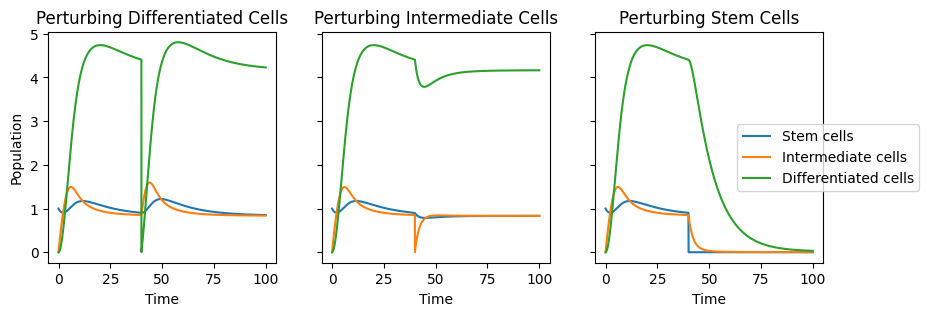

In [59]:
InhibInhibInhib00 = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
  Events=['at time> 40: DIFF= 0;'])

InhibInhibInhib00PerturbINTER = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
  Events=['at time> 40: INTER= 0;'])

InhibInhibInhib00FAIL = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
  Events=['at time> 40: STEM= 0;'])

r = te.loada(InhibInhibInhib00)
s1 = r.simulate(0, 100, 10000,['STEM', 'INTER','DIFF'])
r = te.loada(InhibInhibInhib00PerturbINTER)
s2 = r.simulate(0, 100, 10000,['STEM', 'INTER','DIFF'])
r = te.loada(InhibInhibInhib00FAIL)
s3 = r.simulate(0, 100, 10000,['STEM', 'INTER','DIFF'])

time = np.arange(0, 100, 0.01)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10,3), sharex=True, sharey=True)
ax1.plot(time, s1)
ax1.set_title('Perturbing Differentiated Cells')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax2.plot(time, s2)
ax2.set_title('Perturbing Intermediate Cells')
ax2.set_xlabel('Time')
ax3.plot(time, s3)
ax3.set_title('Perturbing Stem Cells')
ax3.set_xlabel('Time')
fig.legend(['Stem cells', 'Intermediate cells','Differentiated cells'], loc='center right')
plt.show()

Similar to our two stage system, this topology is incredibly robust to perturbations on its differentiated and intermediate cell types, but it still doesn't seem to be able to recover from a complete destruction of the stem cell population. Additionally, this topology presents a biologically accurate difference in the populations of stem, intermediate, and differentiated cell types.

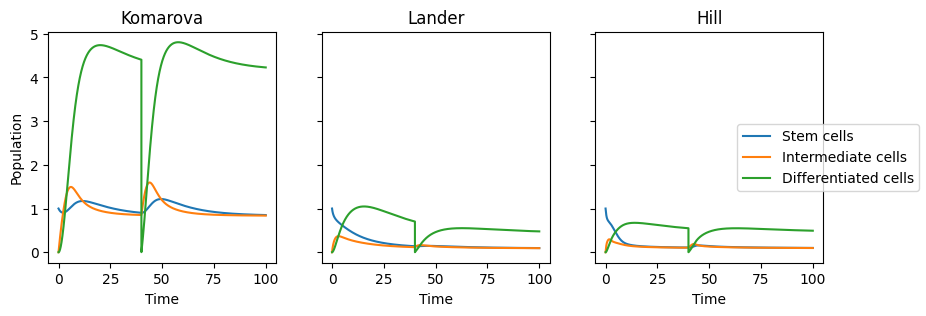

In [60]:
InhibInhibInhib00 = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
  Events=['at time> 40: DIFF= 0;'])

InhibInhibInhib00PerturbINTER = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['lander']('STEM','5'), inhib['lander']('INTER','5'), inhib['lander']('DIFF','5'), '1','1'],
  Events=['at time> 40: DIFF= 0;'])

InhibInhibInhib00FAIL = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['hill']('STEM','5'), inhib['hill']('INTER','5'), inhib['hill']('DIFF','5'), '1','1'],
  Events=['at time> 40: DIFF= 0;'])

r = te.loada(InhibInhibInhib00)
s1 = r.simulate(0, 100, 10000,['STEM', 'INTER','DIFF'])
r = te.loada(InhibInhibInhib00PerturbINTER)
s2 = r.simulate(0, 100, 10000,['STEM', 'INTER','DIFF'])
r = te.loada(InhibInhibInhib00FAIL)
s3 = r.simulate(0, 100, 10000,['STEM', 'INTER','DIFF'])

time = np.arange(0, 100, 0.01)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10,3), sharex=True, sharey=True)
ax1.plot(time, s1)
ax1.set_title('Komarova')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax2.plot(time, s2)
ax2.set_title('Lander')
ax2.set_xlabel('Time')
ax3.plot(time, s3)
ax3.set_title('Hill')
ax3.set_xlabel('Time')
fig.legend(['Stem cells', 'Intermediate cells','Differentiated cells'], loc='center right')
plt.show()

It is apparent that, for this topology, Komarova type control seems to function the best, as we can see that it is able to maintain the appropriate population levels for each cell type. In addition to this, it is also able to maintain a relatively stable differentiated cell population in the face of perturbations.

### Topology #2

![](./assets/Topology_2.png)

In our second topology, stem cells are inhibiting their own division rate, intermediate cells are inhibiting stem cells probability of differentiation, and differentiated cells are inhibiting intermediate cells probability of differentiation. 

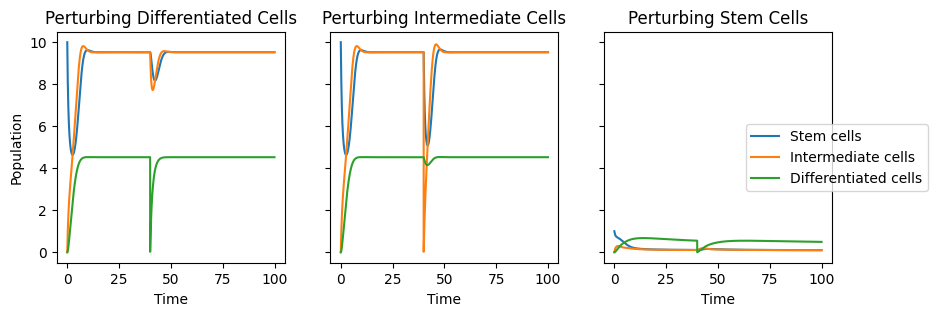

In [61]:
InhibInhib0Inhib0 = threeCompartmentModel(
  STEM='10', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), '1', inhib['komarova']('DIFF','5'),'1'],
  Events=['at time> 40: DIFF= 0;'])
  
InhibInhib0Inhib0PerturbInter = threeCompartmentModel(
  STEM='10', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), '1', inhib['komarova']('DIFF','5'),'1'],
  Events=['at time> 40: INTER= 0;'])

InhibInhib0Inhib0FAIL= threeCompartmentModel(
  STEM='10', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), '1', inhib['komarova']('DIFF','5'),'1'],
  Events=['at time> 40: STEM= 0;'])

r = te.loada(InhibInhib0Inhib0)
s1 = r.simulate(0, 100, 10000,['STEM','INTER','DIFF'])
r.resetAll()
r = te.loada(InhibInhib0Inhib0PerturbInter)
s2 = r.simulate(0, 100, 10000,['STEM','INTER','DIFF'])
r.resetAll()
r = te.loada(InhibInhibInhib00FAIL)
s3 = r.simulate(0, 100, 10000,['STEM', 'INTER','DIFF'])
r.resetAll()

time = np.arange(0, 100, 0.01)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10,3), sharex=True, sharey=True)
ax1.plot(time, s1)
ax1.set_title('Perturbing Differentiated Cells')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax2.plot(time, s2)
ax2.set_title('Perturbing Intermediate Cells')
ax2.set_xlabel('Time')
ax3.plot(time, s3)
ax3.set_title('Perturbing Stem Cells')
ax3.set_xlabel('Time')
fig.legend(['Stem cells', 'Intermediate cells','Differentiated cells'], loc='center right')
plt.show()

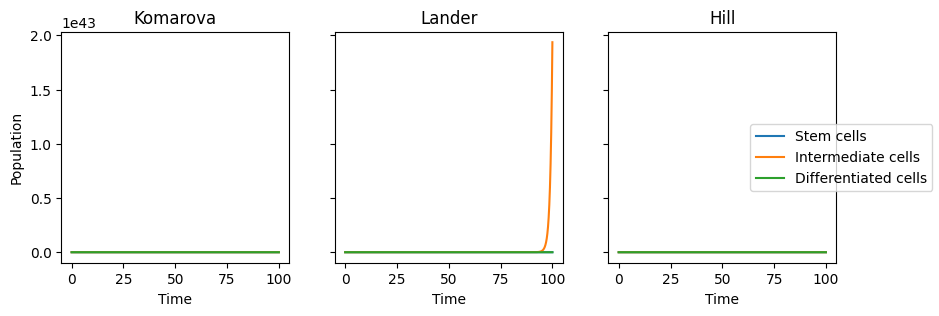

In [62]:
InhibInhib0Inhib0 = threeCompartmentModel(
  STEM='10', INTER='0', DIFF='0', 
  L_S='1',P_S='1',L_I='1',P_I='1',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), '1', inhib['komarova']('DIFF','5'),'1'],
  Events=['at time> 40: DIFF= 0;'])
  
InhibInhib0Inhib0PerturbInter = threeCompartmentModel(
  STEM='10', INTER='0', DIFF='0', 
  L_S='1',P_S='1',L_I='1',P_I='1',D='0.1',
  Control=[inhib['lander']('STEM','5'), inhib['lander']('INTER','5'), '1', inhib['lander']('DIFF','5'),'1'],
  Events=['at time> 40: DIFF= 0;'])

InhibInhib0Inhib0FAIL= threeCompartmentModel(
  STEM='10', INTER='0', DIFF='0', 
  L_S='0.5',P_S='.5',L_I='.5',P_I='.5',D='0.1',
  Control=[inhib['hill']('STEM','5'), inhib['hill']('INTER','5'), '1', inhib['hill']('DIFF','5'),'1'],
  Events=['at time> 40: DIFF= 0;'])

r = te.loada(InhibInhib0Inhib0)
s1 = r.simulate(0, 100, 10000,['STEM','INTER','DIFF'])
r = te.loada(InhibInhib0Inhib0PerturbInter)
s2 = r.simulate(0, 100, 10000,['STEM','INTER','DIFF'])
r = te.loada(InhibInhibInhib00FAIL)
s3 = r.simulate(0, 100, 10000,['STEM', 'INTER','DIFF'])

time = np.arange(0, 100, 0.01)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10,3), sharex=True, sharey=True)
ax1.plot(time, s1)
ax1.set_title('Komarova')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax2.plot(time, s2)
ax2.set_title('Lander')
ax2.set_xlabel('Time')
ax3.plot(time, s3)
ax3.set_title('Hill')
ax3.set_xlabel('Time')
fig.legend(['Stem cells', 'Intermediate cells','Differentiated cells'], loc='center right')
plt.show()

### Try it out for yourself! 

[AN INTRODUCTION TO THE WIDGET APPLICATION FOR THE THREE STAGE NETWORKS]

- [ ] Add a description of the widget here
- Re-explain the parameters and state variables along with their relationships to each other
- Explain each of the resulting plots and visuals that appear
- Encourage them to experiment with the different types of control and see what happens 
--> Recommend a few different combinations? 

### Here, you can see how adjusting several different parameters can change the dynamics of the system. 

To start out, try adjusting the differentiation probability (Stem -> Intermediate) to 0.25 and look at the bifurcation of intermediate cells when adjusting the death rate. Do you see any equilibrium points in the flows? What sort of bifurcations occur?

In [75]:
threeCompartmentWidgets()

Output()